# Multi-Dimensional Scaling (MDS)

MDS is a technique to translate distances between every pair of data points into an abstract cartesian space, wherein the distances of the original space are optimized to be as similar as possible. For instance, given that two data points $\mathbf{x}_i$ and $\mathbf{x}_j$ are elements of the vector space $\mathbb{R}^n$, where $n$ is large, it can be difficult to understand the underlying geometry of the data. Often linear methods are used, such as Principal Component Analysis (PCA), to linearly project the data onto a low-dimensional space. However, the data may have a non-trivial high-dimensional structure, meaning that linear projections just are not good enough. 

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.datasets import load_digits

X_numpy, y_numpy = load_digits(return_X_y=True)

X_numpy.shape, y_numpy.shape

((1797, 64), (1797,))

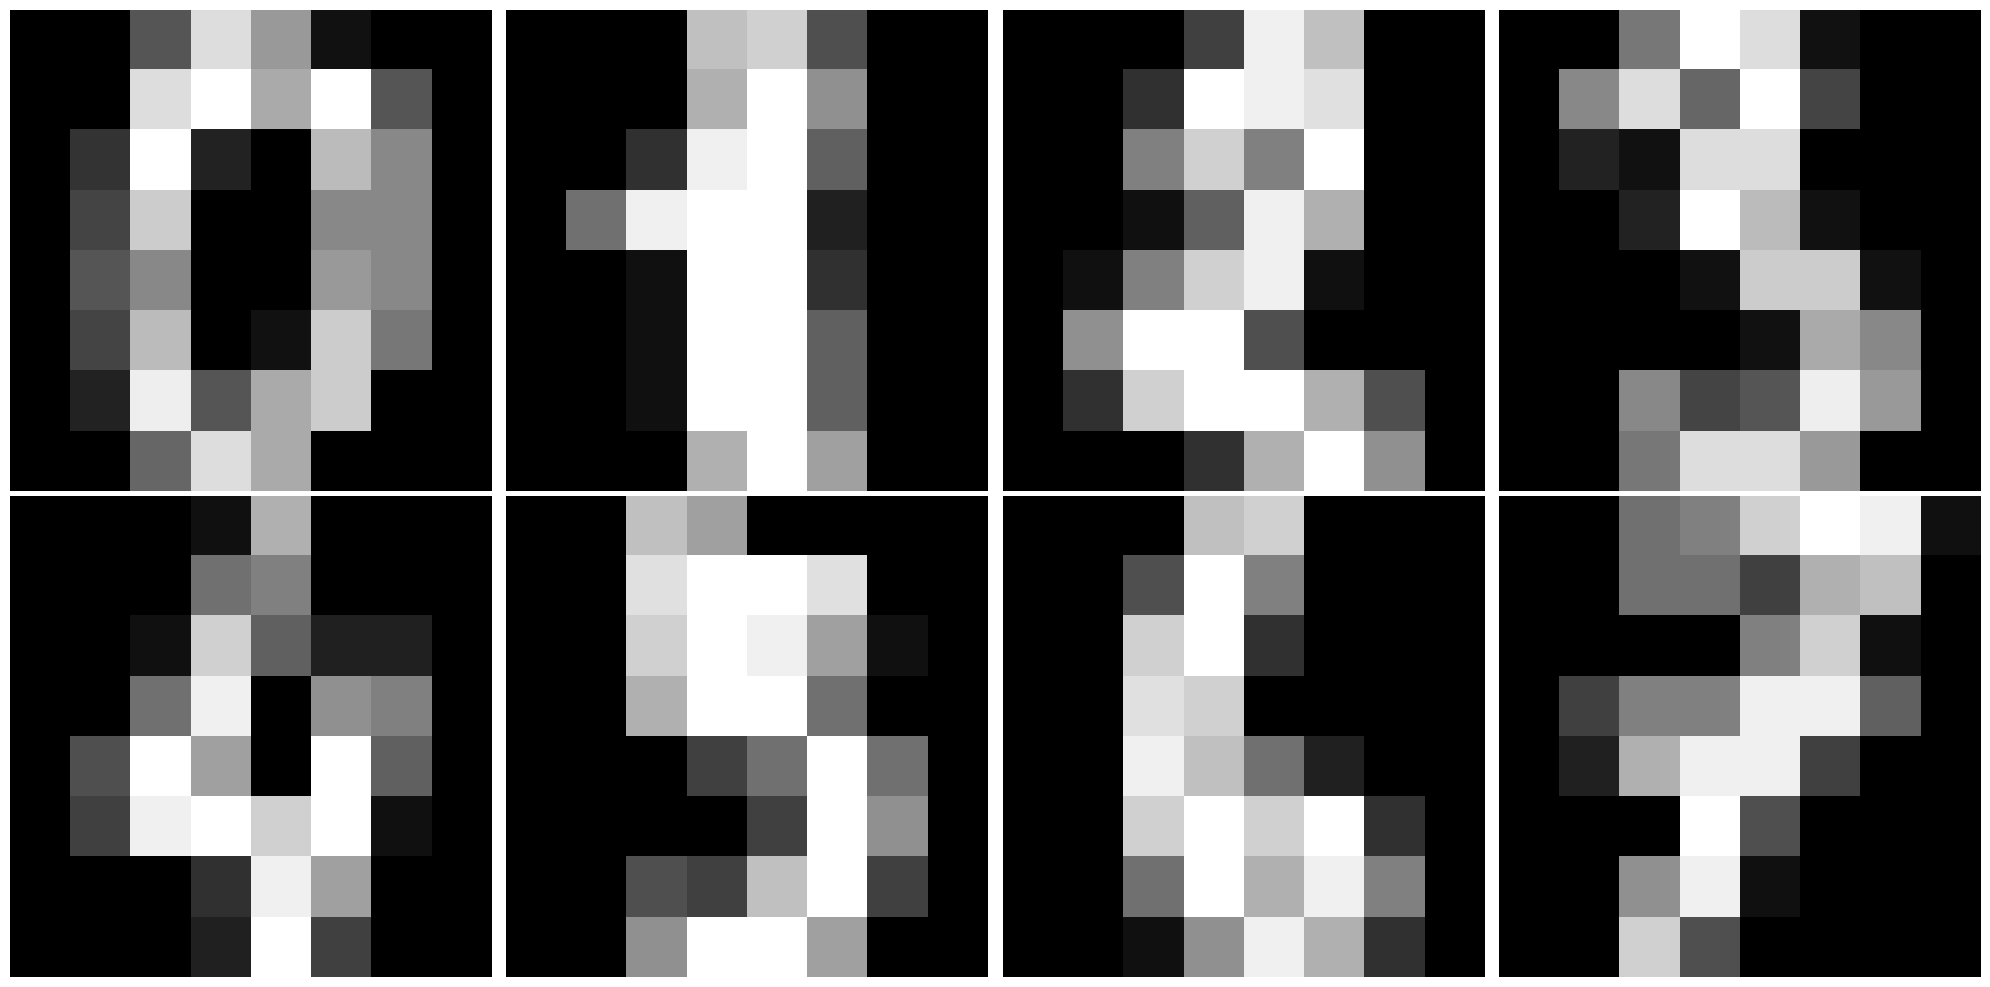

In [3]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(X_numpy[i].reshape(8, 8), cmap='gray')
    ax.axis('off')

plt.tight_layout()

## Key idea behind MDS

The idea behind MDS is to first define for each data point $\mathbf{x}_i$ in the original high-dimensional dataset, a randomly initialized low-dimensional counterpart $\hat{\mathbf{x}}_i$. Thereafter, for both the original dataset $X$ and the randomly initialized low-dimensional counterpart $\hat{X}$, the distance between each pair of data points in computed. There are many distance functions, but for now the Euclidean distance is used between every pair of data points:
$$
    d_{ij} = \sqrt{\sum_{k} (\mathbf{x}_{ik} - \mathbf{x}_{jk})^2}, \qquad \hat{d}_{ij} = \sqrt{\sum_{k} (\hat{\mathbf{x}}_{ik} - \hat{\mathbf{x}}_{jk})^2}
$$
We want the low-dimensional distances $\hat{d}_{ij}$ to closely match the high-dimensional distances $d_{ij}$. The mean-squared error provides a way to quantify the discrepancy between geometry. 
$$
    \mathcal{L} = \sum_{i \neq j} (\hat{d}_{ij} - d_{ij})^2
$$
We just formulated an optimization task, which can be iteratively refined via gradient descent. 

In [4]:
X = torch.tensor(X_numpy)
X_manifold = torch.randn(X.shape[0], 2, requires_grad=True)

# adam + really high learning rate
optim = torch.optim.Adam([X_manifold], lr=50.8)

# original distance matrix only needs to be computed once
dist_original = torch.norm(X[..., None, :] - X[None, ...], p=2, dim=2)

# optimize for 200 iterations
for i in range(200):

    dist_manifold = torch.norm(X_manifold[..., None, :] - X_manifold[None, ...], p=2, dim=2)

    # compute loss
    L = torch.sum((dist_manifold - dist_original)**2)
    if i % 10 == 0: print(f"Iter: {i}, loss: {L.item()}")

    # backprop
    optim.zero_grad()
    L.backward()
    optim.step()

Iter: 0, loss: 7211803156.858053
Iter: 10, loss: 1619748763.7065969
Iter: 20, loss: 1798751371.8629704
Iter: 30, loss: 1421911070.3108377
Iter: 40, loss: 1263743079.9229379
Iter: 50, loss: 1022756232.9015752
Iter: 60, loss: 910397555.1152134
Iter: 70, loss: 866600308.814292
Iter: 80, loss: 847733759.8713129
Iter: 90, loss: 838471450.686809
Iter: 100, loss: 835480303.7234823
Iter: 110, loss: 833367088.5392884
Iter: 120, loss: 832917325.7678888
Iter: 130, loss: 832545642.3115817
Iter: 140, loss: 832452651.274115
Iter: 150, loss: 832426755.7219957
Iter: 160, loss: 832410329.1785872
Iter: 170, loss: 832399956.5357114
Iter: 180, loss: 832396906.8167578
Iter: 190, loss: 832396147.9592441


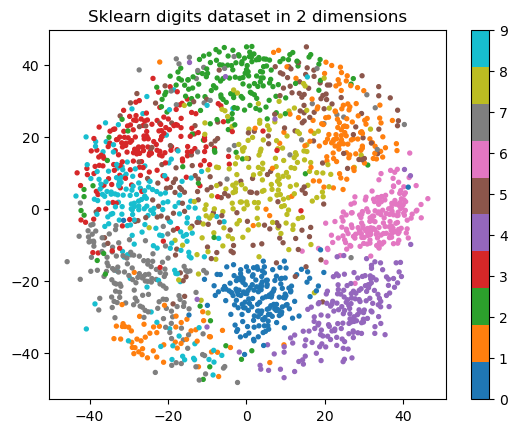

In [ ]:
plt.title("digits dataset using MDS")
plt.scatter(X_manifold[:, 0].detach().numpy(), X_manifold[:, 1].detach().numpy(), c=y_numpy, s=8, cmap='tab10')
cbar = plt.colorbar()

## Comparison with PCA

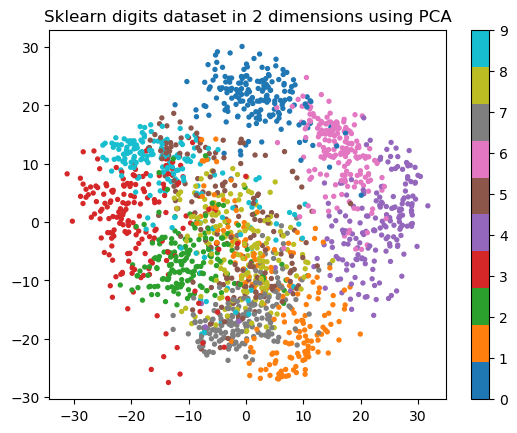

In [ ]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(X_numpy)

plt.title("digits dataset using PCA")
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_numpy, s=8, cmap='tab10')
cbar = plt.colorbar()

## Comparison with Sklearn's MDS

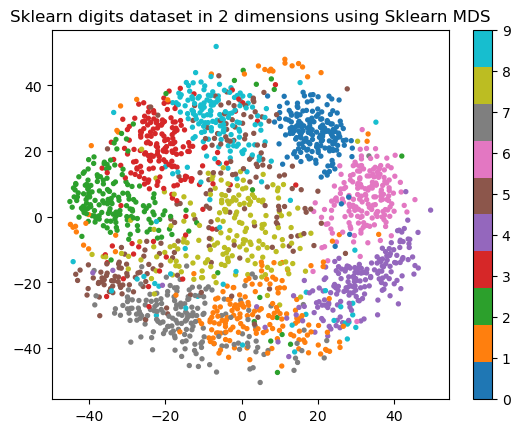

In [ ]:
from sklearn.manifold import MDS

X_mds = MDS(n_components=2, normalized_stress='auto').fit_transform(X_numpy)

plt.title("digits using Sklearn MDS")
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=y_numpy, s=8, cmap='tab10')
cbar = plt.colorbar()

## Sammon's mapping

Defines a loss emphasizing local structure as more important to maintain than global structure
$$
    \mathcal{L} = \sum_{i \neq j} \dfrac{(\hat{d}_{ij} - d_{ij})^2}{d_{ij}}
$$

In [8]:
X = torch.tensor(X_numpy)
X_sammon = torch.randn(X.shape[0], 2, requires_grad=True)

# adam + really high learning rate
optim = torch.optim.Adam([X_sammon], lr=50.8)

# original distance matrix only needs to be computed once
dist_original = torch.norm(X[..., None, :] - X[None, ...], p=2, dim=2)

# optimize for 200 iterations
for i in range(200):

    dist_manifold = torch.norm(X_sammon[..., None, :] - X_sammon[None, ...], p=2, dim=2)

    # compute loss
    L = torch.sum((dist_manifold - dist_original)**2 / (dist_original + 1e-6))
    if i % 10 == 0: print(f"Iter: {i}, loss: {L.item()}")

    # backprop
    optim.zero_grad()
    L.backward()
    optim.step()

Iter: 0, loss: 144894853.8444445
Iter: 10, loss: 34193752.19406576
Iter: 20, loss: 38698570.22806299
Iter: 30, loss: 29787662.74842589
Iter: 40, loss: 26549026.01084035
Iter: 50, loss: 23262200.96606875
Iter: 60, loss: 20290639.78537991
Iter: 70, loss: 19169176.647674587
Iter: 80, loss: 18530539.38931042
Iter: 90, loss: 18327650.861019716
Iter: 100, loss: 18255145.634947162
Iter: 110, loss: 18226874.044376254
Iter: 120, loss: 18215171.558908463
Iter: 130, loss: 18209186.64601657
Iter: 140, loss: 18206845.106469307
Iter: 150, loss: 18205695.146249533
Iter: 160, loss: 18204091.469846297
Iter: 170, loss: 18201353.64997451
Iter: 180, loss: 18201007.81619875
Iter: 190, loss: 18200491.13867435


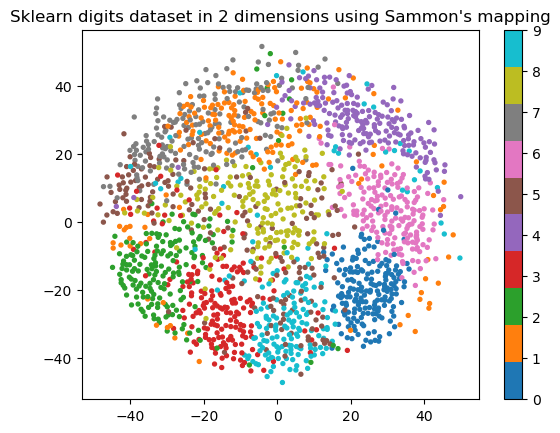

In [ ]:
plt.title("digits using Sammon's mapping")
plt.scatter(X_sammon[:, 0].detach().numpy(), X_sammon[:, 1].detach().numpy(), c=y_numpy, s=8, cmap='tab10')
cbar = plt.colorbar()

## Nearest Neighbour Graph visualization

$$
    \mathcal{L} = \sum_{i \neq j} \frac{1}{\hat{d}_{ij}} + \frac{1}{2} \sum_{(i, j) \in E} (\hat{d}_{ij} - d_{ij})^2
$$

In [90]:
k = 3

X = torch.tensor(X_numpy)
X_nn = torch.randn(X.shape[0], 2, requires_grad=True)

# adam + really high learning rate
optim = torch.optim.Adam([X_nn], lr=0.01)

# original distance matrix only needs to be computed once
dist_original = torch.norm(X[..., None, :] - X[None, ...], p=2, dim=2)
idx = dist_original.argsort(dim=0)
dist_original_sorted = torch.take_along_dim(dist_original, idx, dim=0)
dist_original_nn = dist_original_sorted[1:k+1, :] # take only the k nearest neighbours

history = []

for i in range(1000):

    dist_manifold = torch.norm(X_nn[..., None, :] - X_nn[None, ...], p=2, dim=2)
    idx = dist_manifold.argsort(dim=0)
    dist_manifold_sorted = torch.take_along_dim(dist_manifold, idx, dim=0)
    dist_manifold_nn = dist_manifold_sorted[1:k+1, :] # take only the k nearest neighbours

    # compute loss
    L = torch.sum(1/(dist_manifold + 1e-8)) + 0.5 * torch.sum((dist_manifold_nn - dist_original_nn)**2)
    
    if i % 100 == 0: print(f"Iter: {i}, loss: {L.item()}")

    history.append(L.item())

    # backprop
    optim.zero_grad()
    L.backward()
    optim.step()

Iter: 0, loss: 179703780702.2983
Iter: 100, loss: 179702611158.56122
Iter: 200, loss: 179702214045.0445
Iter: 300, loss: 179702046939.55984
Iter: 400, loss: 179701896531.65872
Iter: 500, loss: 179701795427.17056
Iter: 600, loss: 179701678044.5775
Iter: 700, loss: 179701659024.3215
Iter: 800, loss: 179701574511.93124
Iter: 900, loss: 179701539310.90244


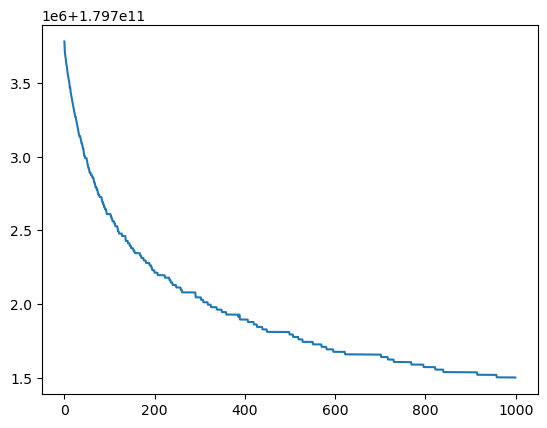

In [92]:
plt.plot(history)

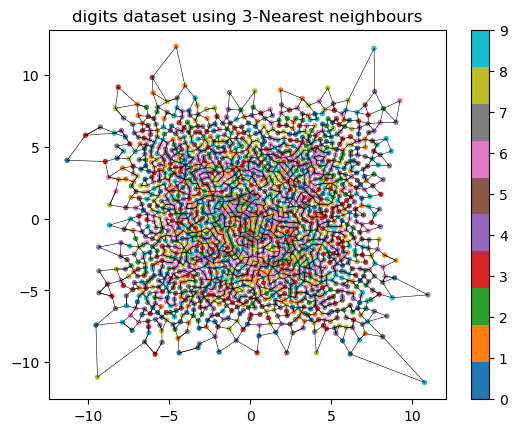

In [93]:
X_nn_np = X_nn.detach().numpy()

plt.title("digits dataset using 3-Nearest neighbours")

dist_manifold = torch.norm(X_nn[..., None, :] - X_nn[None, ...], p=2, dim=2)
idx = dist_manifold.argsort(dim=0)
dist_manifold_sorted = torch.take_along_dim(dist_manifold, idx, dim=0)
dist_manifold_nn = dist_manifold_sorted[1:k, :]

for j, idx_row in enumerate(idx[1:k, :].T):
    for i in idx_row:
        i = i.item()
        plt.plot([X_nn_np[j, 0], X_nn_np[i, 0]], [X_nn_np[j, 1], X_nn_np[i, 1]], c='k', linewidth=0.4)

plt.scatter(X_nn_np[:, 0], X_nn_np[:, 1], c=y_numpy, s=8, cmap='tab10')
cbar = plt.colorbar()

### Breast cancer dataset

In [94]:
from sklearn.datasets import load_breast_cancer

X_bc, y_bc = load_breast_cancer(return_X_y=True)

X_bc.shape, y_bc.shape

((569, 30), (569,))

In [95]:
k = 3

X = torch.tensor(X_bc)
X_nn = torch.randn(X.shape[0], 2, requires_grad=True)

# adam + really high learning rate
optim = torch.optim.Adam([X_nn], lr=0.5)

# original distance matrix only needs to be computed once
dist_original = torch.norm(X[..., None, :] - X[None, ...], p=2, dim=2)
idx = dist_original.argsort(dim=0)
dist_original_sorted = torch.take_along_dim(dist_original, idx, dim=0)
dist_original_nn = dist_original_sorted[1:k+1, :] # take only the k nearest neighbours

history = []

# optimize for 200 iterations
for i in range(1000):

    dist_manifold = torch.norm(X_nn[..., None, :] - X_nn[None, ...], p=2, dim=2)
    idx = dist_manifold.argsort(dim=0)
    dist_manifold_sorted = torch.take_along_dim(dist_manifold, idx, dim=0)
    dist_manifold_nn = dist_manifold_sorted[1:k+1, :] # take only the k nearest neighbours

    # compute loss
    L = torch.sum(1/(dist_manifold + 1e-8)) + 0.5 * torch.sum((dist_manifold_nn - dist_original_nn)**2)
    
    if i % 100 == 0: print(f"Iter: {i}, loss: {L.item()}")

    history.append(L.item())

    # backprop
    optim.zero_grad()
    L.backward()
    optim.step()

Iter: 0, loss: 56906910916.19091
Iter: 100, loss: 56906229445.563545
Iter: 200, loss: 56905859689.082924
Iter: 300, loss: 56905529802.412674
Iter: 400, loss: 56905225273.67735
Iter: 500, loss: 56904930623.25988
Iter: 600, loss: 56904659533.33371
Iter: 700, loss: 56904418965.63901
Iter: 800, loss: 56904206469.6663
Iter: 900, loss: 56904008744.56565


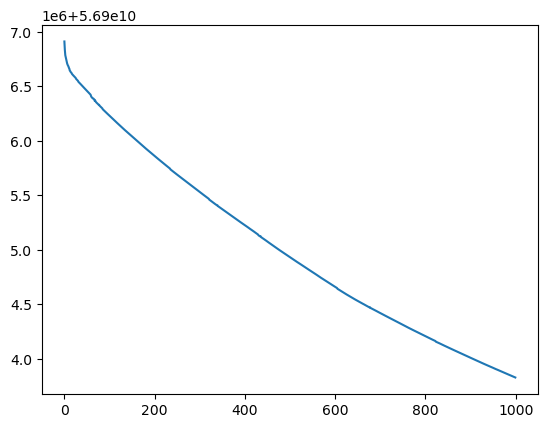

In [96]:
plt.plot(history)

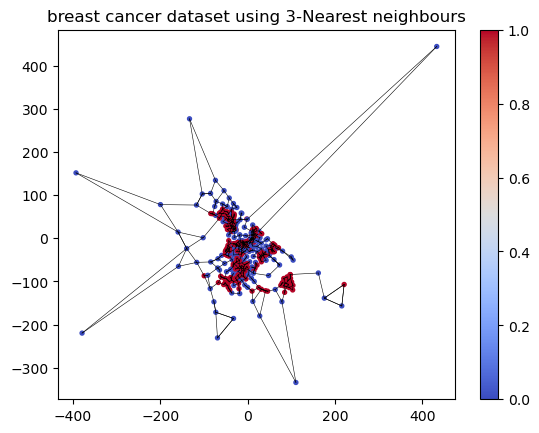

In [97]:
X_nn_np = X_nn.detach().numpy()

plt.title("breast cancer dataset using 3-Nearest neighbours")

dist_manifold = torch.norm(X_nn[..., None, :] - X_nn[None, ...], p=2, dim=2)
idx = dist_manifold.argsort(dim=0)
dist_manifold_sorted = torch.take_along_dim(dist_manifold, idx, dim=0)
dist_manifold_nn = dist_manifold_sorted[1:k, :]

for j, idx_row in enumerate(idx[1:k, :].T):
    for i in idx_row:
        i = i.item()
        plt.plot([X_nn_np[j, 0], X_nn_np[i, 0]], [X_nn_np[j, 1], X_nn_np[i, 1]], c='k', linewidth=0.4)

plt.scatter(X_nn_np[:, 0], X_nn_np[:, 1], c=y_bc, s=8, cmap='coolwarm')
cbar = plt.colorbar()